## 영어 Word2Vec 만들기

In [8]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7eafe5f93550>)

In [9]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

parse_text = '\n'.join(target_text.xpath('//content/text()')) # <content> ~ </content> 부분의 내용을 개행하며 하나의 문자열로 통합
content_text = re.sub(r'\([^)]*\)', '', parse_text)           # 괄호로 묶인 내부에 있는 불필요한 부분 제거
sent_text = sent_tokenize(content_text)                       # 문자열을 sentence tokenizer로 문장 토큰화

normalized_text = []
for string in sent_text:
  tokens = re.sub(r"[^a-z0-9]+", " ", string.lower()) # 구두점 제거, 소문자 변환
  normalized_text.append(tokens)                      # 정규화된 문장 토큰들로 만들고

result = [word_tokenize(sentence) for sentence in normalized_text]  # 각 문장마다 단어 토큰화를 진행하여 총 단어 토큰들로 이루어진 Corpus 생성
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [13]:
for line in result[:3]:
  print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


In [16]:
cnt = 0
for line in result:
  cnt += len(line)
print("총 단어 토큰의 개수 : {}".format(cnt))

총 단어 토큰의 개수 : 4475758


In [15]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0) # 450만개 가량의 토큰에 대한 Word2Vec 학습(40초 정도 소요)
# vector_size : 임베딩 벡터의 차원 --> 사용자 지정
# window : context window 크기
# min_count : 단어 최소 빈도수 제한(빈도가 적은 단어들은 학습에서 제외)
# workers : 학습을 위한 프로세스의 수
# sg : 0은 CBOW, 1은 Skip-Gram

In [17]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8461389541625977), ('guy', 0.822187602519989), ('lady', 0.7682960033416748), ('girl', 0.7492524981498718), ('boy', 0.7479900121688843), ('gentleman', 0.7438039779663086), ('soldier', 0.741807222366333), ('kid', 0.6926848292350769), ('david', 0.6874379515647888), ('poet', 0.6801223158836365)]


In [18]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장(약 25MB)

In [19]:
from gensim.models import KeyedVectors
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [21]:
model_result = loaded_model.most_similar("man") # 로드한 모델로 단어의 유사도 계산
print(model_result)

[('woman', 0.8461389541625977), ('guy', 0.822187602519989), ('lady', 0.7682960033416748), ('girl', 0.7492524981498718), ('boy', 0.7479900121688843), ('gentleman', 0.7438039779663086), ('soldier', 0.741807222366333), ('kid', 0.6926848292350769), ('david', 0.6874379515647888), ('poet', 0.6801223158836365)]


Gensim의 Word2Vec 모델에서 'most_similar' 메소드로 단어의 유사도 계산할 때 사용되는 방식은 코사인 유사도(cosine similarity)이다    
따라서 단어 옆의 수치는 두 단어 사이의 코사인 유사도 값이며 1에 가까울수록 유사한 것이다.

## 한국어 Word2Vec 만들기 (네이버 영화 리뷰)

In [ ]:
# !pip install konlpy

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from tqdm import tqdm

In [25]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7eafa5302170>)

In [43]:
train_data = pd.read_table('ratings.txt')

In [44]:
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [45]:
print(len(train_data)) # 20만개의 샘플이 존재

200000


In [46]:
train_data.info()
# train_data.isnull().values.any() # 결측값이 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        200000 non-null  int64 
 1   document  199992 non-null  object
 2   label     200000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [47]:
train_data.dropna(inplace=True) # 결측값을 제거
train_data.info()               # 총 199992개

<class 'pandas.core.frame.DataFrame'>
Index: 199992 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        199992 non-null  int64 
 1   document  199992 non-null  object
 2   label     199992 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.1+ MB


In [54]:
# 기초 자연어 처리 2권 내용과 다르게 버전 업 되면서 regex=True가 붙어야 하는 듯하다
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [56]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 Okt를 사용한 토큰화 작업
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
  tokenized_sentence = okt.morphs(sentence, stem=True)
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
  tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [26:47<00:00, 124.39it/s]


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


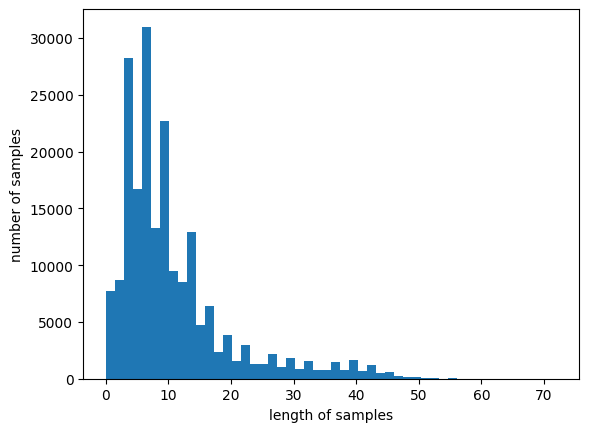

In [57]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :', max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :', sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [58]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=5, workers=4, sg=0)
model.wv.vectors.shape

(16477, 100)

In [59]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8693625330924988), ('최민수', 0.8670225143432617), ('안성기', 0.8554515838623047), ('송강호', 0.8548626899719238), ('이정재', 0.8547409772872925), ('설경구', 0.8544758558273315), ('김명민', 0.8479315638542175), ('엄태웅', 0.8386328220367432), ('박신양', 0.8353831171989441), ('엄정화', 0.8330356478691101)]


In [60]:
print(model.wv.most_similar("히어로"))

[('무협', 0.8685901761054993), ('호러', 0.8665418028831482), ('슬래셔', 0.8571310043334961), ('느와르', 0.8512507081031799), ('정통', 0.8254776000976562), ('물의', 0.8198303580284119), ('무비', 0.8172382712364197), ('블록버스터', 0.8112839460372925), ('물', 0.7974081635475159), ('로코', 0.7907182574272156)]


In [66]:
model.wv.similarity("노무현", "박정희")

0.7732689

## 사전 훈련된(pretrained) Word2Vec 임베딩

In [70]:
# !pip install gdown

In [71]:
# 2. 파일 ID 추출 및 다운로드
import gdown

# Google Drive 파일 ID
file_id = '0B7XkCwpI5KDYNlNUTTlSS21pQmM'
# 다운로드할 파일 이름
output = 'GoogleNewsvectors-negative300.bin.gz'

# 파일 다운로드
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
From (redirected): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&confirm=t&uuid=5d1f91b1-ad2f-48c9-bec3-516d35ce83f8
To: /content/GoogleNewsvectors-negative300.bin.gz
100%|██████████| 1.65G/1.65G [00:31<00:00, 51.5MB/s]


'GoogleNewsvectors-negative300.bin.gz'

In [72]:
import gensim
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format("GoogleNewsvectors-negative300.bin.gz", binary=True)

In [73]:
print(word2vec_model.vectors.shape)

(3000000, 300)


In [74]:
print(word2vec_model.similarity('this', 'is'))
print(word2vec_model.similarity('post', 'book'))

0.40797037
0.057204384


In [75]:
word2vec_model.most_similar("post")

[('posts', 0.5952650904655457),
 ('www.pressbanner.com', 0.570246160030365),
 ('Katrice_Rachal_Thanks', 0.541118323802948),
 ('balmy_breezy_afternoon', 0.5282716155052185),
 ('Trackback_URL', 0.520129382610321),
 ('disabled_pinging', 0.510864794254303),
 ('Wazen_Dhehiba_border', 0.4548766314983368),
 ('mineral_diorite_porphyry', 0.45073622465133667),
 ('e_mail_editorNTL@gannetthg.com', 0.4473777115345001),
 ('tips_+_adam@lifehacker.com', 0.4456864595413208)]